<a href="https://colab.research.google.com/github/bsshreesha/Physics_Informed_Neural_Network/blob/main/MHD_Realistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting PINN training for 10000 epochs...
Epoch 1/10000 - Total Loss: 2.1273e+01, ODE Loss: 1.2437e-02, BC Loss: 2.1261e+00
Epoch 500/10000 - Total Loss: 1.0828e-02, ODE Loss: 1.0585e-02, BC Loss: 2.4351e-05
Epoch 1000/10000 - Total Loss: 7.5973e-03, ODE Loss: 7.4411e-03, BC Loss: 1.5612e-05
Epoch 1500/10000 - Total Loss: 6.2146e-03, ODE Loss: 6.0790e-03, BC Loss: 1.3555e-05
Epoch 2000/10000 - Total Loss: 4.9408e-03, ODE Loss: 4.8473e-03, BC Loss: 9.3547e-06
Epoch 2500/10000 - Total Loss: 3.4264e-03, ODE Loss: 3.3796e-03, BC Loss: 4.6846e-06
Epoch 3000/10000 - Total Loss: 1.9833e-03, ODE Loss: 1.9222e-03, BC Loss: 6.1148e-06
Epoch 3500/10000 - Total Loss: 2.2266e-03, ODE Loss: 1.2687e-03, BC Loss: 9.5797e-05
Epoch 4000/10000 - Total Loss: 7.8212e-04, ODE Loss: 7.8132e-04, BC Loss: 7.9982e-08
Epoch 4500/10000 - Total Loss: 5.6137e-04, ODE Loss: 5.6040e-04, BC Loss: 9.7852e-08
Epoch 5000/10000 - Total Loss: 5.3665e-04, ODE Loss: 4.2481e-04, BC Loss: 1.1184e-05
Epoch 5500/10000 - Total L

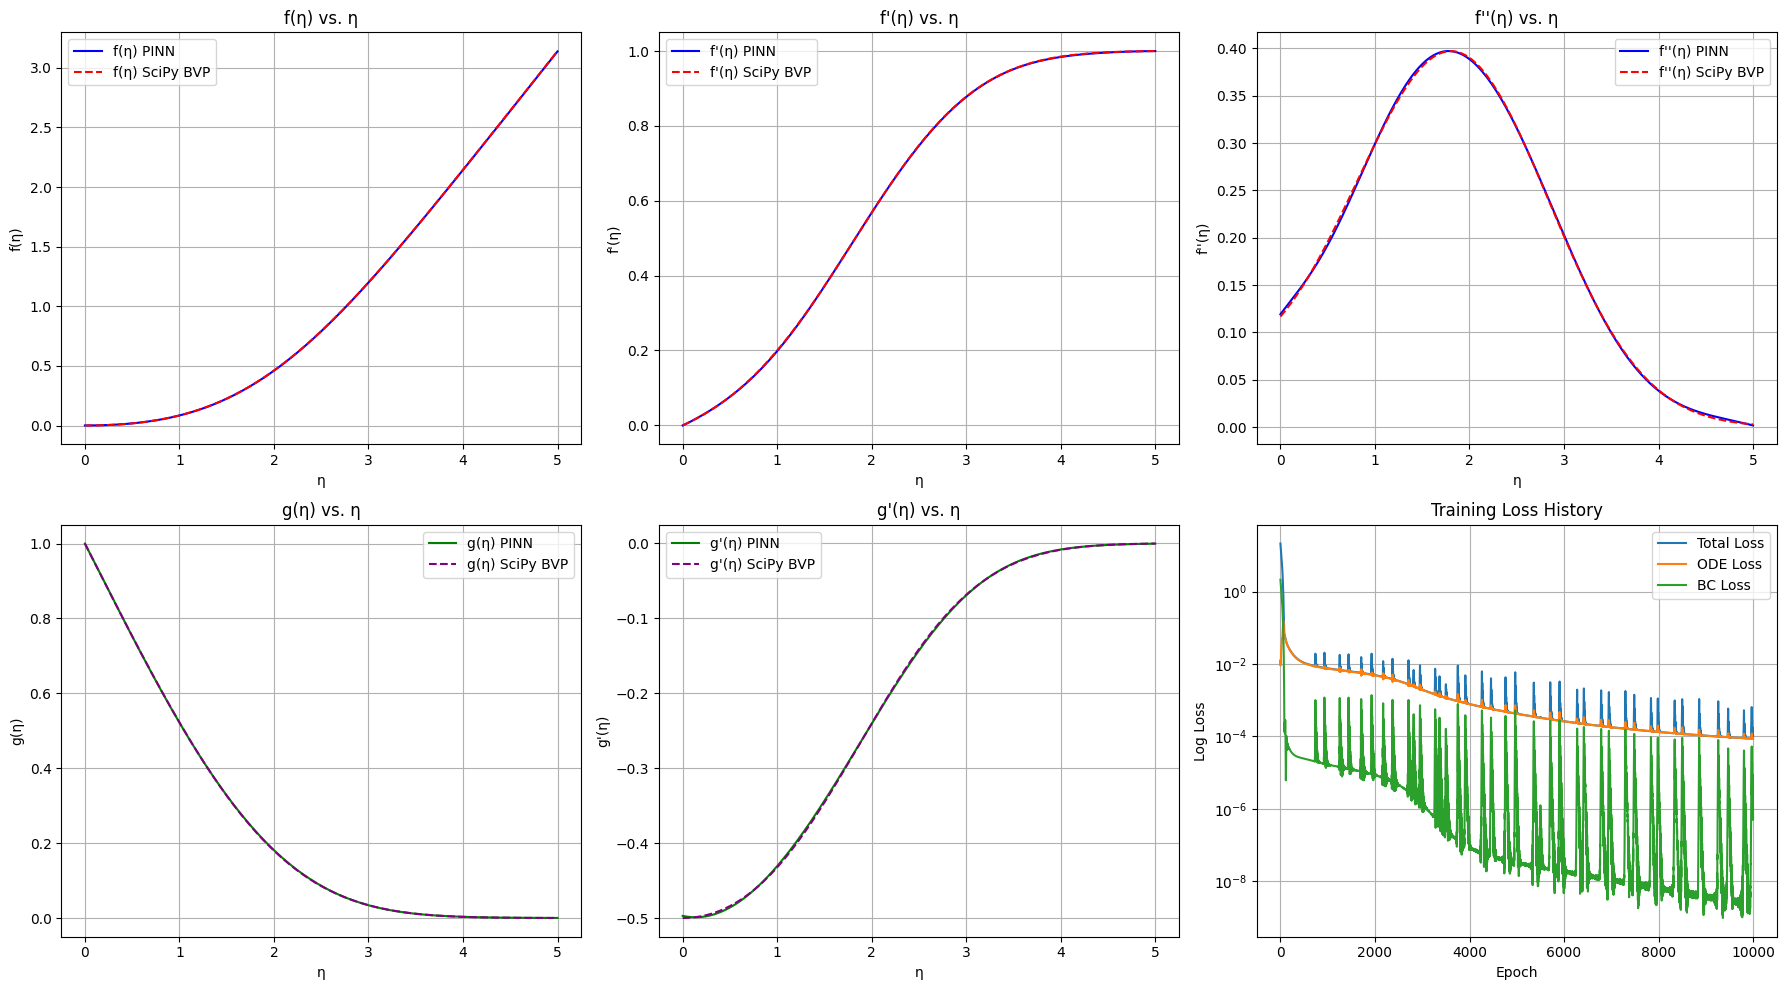


--- Final Loss Metrics ---
Final Total Loss: 9.1657e-05
Final ODE Residual Loss: 8.6380e-05
Final Boundary Condition Loss: 5.2773e-07
Mean Squared Error (PINN vs SciPy) for f(η): 2.2365e-06
Mean Squared Error (PINN vs SciPy) for g(η): 2.6788e-07

Core neural network model saved to mhd_pinn_model.h5

--- Conceptual Discussion: Reinforcement Enabled PINN ---

While this implementation provides a standard PINN, enabling it with Reinforcement Learning (RL)
is an advanced step. Here's how it could be conceptualized:

1.  **Goal of RL:** To make the PINN training process more efficient, robust, or to achieve
    better accuracy by intelligently guiding aspects of the training.

2.  **RL Components:**
    * **Agent:** The RL algorithm (e.g., Q-learning, DQN, PPO, A2C) that learns a policy.
    * **Environment:** The PINN training process itself.
    * **State:** A representation of the current status of the PINN training. This could include:
        * Current epoch number.
        * Current 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp

# Suppress TensorFlow warnings for cleaner output
import logging
tf.get_logger().setLevel(logging.ERROR)

# --- 1. Define MHD Parameters and Domain ---
M = 1.0  # Hartmann number (example value)
Pr_m = 1.0  # Magnetic Prandtl number (example value)
ETA_MAX = 5.0  # Upper limit of the domain for eta

# --- 2. Define the Neural Network Architecture (Keras Functional API) ---
def create_pinn_model(num_hidden_layers=4, num_neurons_per_layer=32):
    eta_input = tf.keras.Input(shape=(1,), name="eta")
    x = eta_input
    for _ in range(num_hidden_layers):
        x = tf.keras.layers.Dense(num_neurons_per_layer, activation="tanh")(x)
    f_output = tf.keras.layers.Dense(1, name="f", activation='linear')(x)
    g_output = tf.keras.layers.Dense(1, name="g", activation='linear')(x)
    return tf.keras.Model(inputs=eta_input, outputs=[f_output, g_output])

# --- 3. Define the PINN Model (subclassing tf.keras.Model) ---
class MHD_PINN(tf.keras.Model):
    def __init__(self, nn_approximator, m_param, pr_m_param, eta_max_val, **kwargs):
        super().__init__(**kwargs)
        self.nn = nn_approximator
        self.M = tf.constant(m_param, dtype=tf.float32)
        self.Pr_m = tf.constant(pr_m_param, dtype=tf.float32)
        self.eta_max = tf.constant(eta_max_val, dtype=tf.float32)
        self.lambda_ode = tf.constant(1.0, dtype=tf.float32)
        self.lambda_bc = tf.constant(10.0, dtype=tf.float32)

    def call(self, eta):
        return self.nn(eta)

    @tf.function
    def compute_derivatives_and_residuals(self, eta_collocation):
        with tf.GradientTape(persistent=True) as tape3:
            tape3.watch(eta_collocation)
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(eta_collocation)
                with tf.GradientTape(persistent=True) as tape1:
                    tape1.watch(eta_collocation)
                    f_pred, g_pred = self.nn(eta_collocation)
                df_deta = tape1.gradient(f_pred, eta_collocation)
                dg_deta = tape1.gradient(g_pred, eta_collocation)
            df_deta2 = tape2.gradient(df_deta, eta_collocation)
            dg_deta2 = tape2.gradient(dg_deta, eta_collocation)
        df_deta3 = tape3.gradient(df_deta2, eta_collocation)
        del tape1, tape2, tape3

        f, f_prime, f_prime_prime, f_prime_prime_prime = f_pred, df_deta, df_deta2, df_deta3
        g, g_prime, g_prime_prime = g_pred, dg_deta, dg_deta2

        residual_f = f_prime_prime_prime + f * f_prime_prime - \
                     self.M * (g * g_prime_prime + f_prime_prime * g)
        residual_g = g_prime_prime + self.Pr_m * (f * g_prime - f_prime * g)
        return residual_f, residual_g

    @tf.function
    def loss_fn(self, eta_collocation, eta_boundary_0, eta_boundary_max):
        res_f, res_g = self.compute_derivatives_and_residuals(eta_collocation)
        loss_ode_f = tf.reduce_mean(tf.square(res_f))
        loss_ode_g = tf.reduce_mean(tf.square(res_g))
        total_loss_ode = loss_ode_f + loss_ode_g

        f_at_0, g_at_0 = self.nn(eta_boundary_0)
        with tf.GradientTape() as tape_bc0:
            tape_bc0.watch(eta_boundary_0)
            f_for_fprime0, _ = self.nn(eta_boundary_0)
        f_prime_at_0 = tape_bc0.gradient(f_for_fprime0, eta_boundary_0)

        bc_f0 = f_at_0 - 0.0
        bc_fprime0 = f_prime_at_0 - 0.0
        bc_g0 = g_at_0 - 1.0

        _, g_at_max = self.nn(eta_boundary_max)
        with tf.GradientTape() as tape_bc_max:
            tape_bc_max.watch(eta_boundary_max)
            f_for_fprimemax, _ = self.nn(eta_boundary_max)
        f_prime_at_max = tape_bc_max.gradient(f_for_fprimemax, eta_boundary_max)

        bc_fprime_max = f_prime_at_max - 1.0
        bc_g_max = g_at_max - 0.0

        loss_bc = tf.reduce_mean(tf.square(bc_f0)) + \
                  tf.reduce_mean(tf.square(bc_fprime0)) + \
                  tf.reduce_mean(tf.square(bc_g0)) + \
                  tf.reduce_mean(tf.square(bc_fprime_max)) + \
                  tf.reduce_mean(tf.square(bc_g_max))

        total_loss = self.lambda_ode * total_loss_ode + self.lambda_bc * loss_bc
        return total_loss, total_loss_ode, loss_bc

    # Renamed from train_step to gradient_update_step
    @tf.function
    def gradient_update_step(self, optimizer, eta_collocation, eta_boundary_0, eta_boundary_max):
        with tf.GradientTape() as tape:
            total_loss, loss_ode, loss_bc = self.loss_fn(eta_collocation, eta_boundary_0, eta_boundary_max)
        gradients = tape.gradient(total_loss, self.nn.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.nn.trainable_variables))
        return total_loss, loss_ode, loss_bc

# --- 4. Generate Training Data (Collocation and Boundary Points) ---
N_collocation = 2000
N_boundary = 100
eta_col_np = np.random.uniform(0.0, ETA_MAX, (N_collocation, 1)).astype(np.float32)
eta_b0_np = np.full((N_boundary, 1), 0.0, dtype=np.float32)
eta_b_max_np = np.full((N_boundary, 1), ETA_MAX, dtype=np.float32)
eta_col = tf.constant(eta_col_np)
eta_b0 = tf.constant(eta_b0_np)
eta_b_max = tf.constant(eta_b_max_np)

# --- 5. Training the PINN ---
nn_core_model = create_pinn_model()
pinn_solver = MHD_PINN(nn_core_model, M, Pr_m, ETA_MAX)

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=500, decay_rate=0.9, staircase=True
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

epochs = 10000 # Adjusted for typical PINN training, can be much higher
print_interval = 500

print(f"Starting PINN training for {epochs} epochs...")
history_loss = []
history_loss_ode = []
history_loss_bc = []

for epoch in range(epochs):
    # Call the renamed method
    total_loss_val, loss_ode_val, loss_bc_val = pinn_solver.gradient_update_step(
        optimizer, eta_col, eta_b0, eta_b_max
    )
    history_loss.append(total_loss_val.numpy())
    history_loss_ode.append(loss_ode_val.numpy())
    history_loss_bc.append(loss_bc_val.numpy())

    if (epoch + 1) % print_interval == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Total Loss: {total_loss_val:.4e}, ODE Loss: {loss_ode_val:.4e}, BC Loss: {loss_bc_val:.4e}")

print("Training finished.")


# --- 6. Prediction and Plotting ---
print("\nGenerating predictions and plots...")
eta_plot_tf = tf.constant(np.linspace(0, ETA_MAX, 200).reshape(-1, 1).astype(np.float32))
f_pinn_pred_tf, g_pinn_pred_tf = pinn_solver.nn(eta_plot_tf) # Use direct call for prediction

f_pinn_pred = f_pinn_pred_tf.numpy()
g_pinn_pred = g_pinn_pred_tf.numpy()


# For f_prime, f_prime_prime, g_prime from PINN (using automatic differentiation on predicted f,g)
with tf.GradientTape(persistent=True) as tape_plot2:
    tape_plot2.watch(eta_plot_tf)
    with tf.GradientTape(persistent=True) as tape_plot1:
        tape_plot1.watch(eta_plot_tf)
        f_for_plot, g_for_plot = pinn_solver.nn(eta_plot_tf)
    f_prime_pinn_pred_tf = tape_plot1.gradient(f_for_plot, eta_plot_tf)
    g_prime_pinn_pred_tf = tape_plot1.gradient(g_for_plot, eta_plot_tf)
f_prime_prime_pinn_pred_tf = tape_plot2.gradient(f_prime_pinn_pred_tf, eta_plot_tf)

del tape_plot1, tape_plot2

f_prime_pinn_pred = f_prime_pinn_pred_tf.numpy()
g_prime_pinn_pred = g_prime_pinn_pred_tf.numpy()
f_prime_prime_pinn_pred = f_prime_prime_pinn_pred_tf.numpy()


# --- 7. Numerical Solution (SciPy BVP solver) for Comparison ---
def mhd_ode_system_scipy(eta, y, M_param, Pr_m_param):
    y1, y2, y3, y4, y5 = y
    dy1 = y2
    dy2 = y3
    dy5 = -Pr_m_param * (y1 * y5 - y2 * y4) # g''
    dy3 = -y1 * y3 + M_param * (y4 * dy5 + y3 * y4) # f'''
    dy4 = y5
    return np.vstack((dy1, dy2, dy3, dy4, dy5))

def mhd_bc_scipy(ya, yb, M_param, Pr_m_param):
    return np.array([ya[0], ya[1], yb[1] - 1, ya[3] - 1, yb[3]])

eta_scipy_mesh = np.linspace(0, ETA_MAX, 50)
y_init_guess = np.zeros((5, eta_scipy_mesh.size))
y_init_guess[1, :] = eta_scipy_mesh / ETA_MAX
y_init_guess[3, :] = 1 - (eta_scipy_mesh / ETA_MAX)

print("Solving with SciPy BVP solver for comparison...")
scipy_solved = False
try:
    sol_scipy = solve_bvp(lambda eta, y: mhd_ode_system_scipy(eta, y, M, Pr_m),
                          lambda ya, yb: mhd_bc_scipy(ya, yb, M, Pr_m),
                          eta_scipy_mesh,
                          y_init_guess,
                          verbose=0, max_nodes=3000, tol=1e-5)
    if sol_scipy.success:
        print(f"SciPy BVP solver converged: {sol_scipy.message}")
        # Evaluate SciPy solution on the same points as PINN plot
        y_scipy_plot = sol_scipy.sol(eta_plot_tf.numpy().flatten()) # Pass flattened numpy array for eta values
        f_scipy = y_scipy_plot[0]
        f_prime_scipy = y_scipy_plot[1]
        f_prime_prime_scipy = y_scipy_plot[2]
        g_scipy = y_scipy_plot[3]
        g_prime_scipy = y_scipy_plot[4]
        scipy_solved = True
    else:
        print(f"SciPy BVP solver FAILED to converge: {sol_scipy.message}")
except Exception as e:
    print(f"Error during SciPy BVP solution: {e}")

# Plotting results
plt.figure(figsize=(18, 10))
eta_plot_numpy = eta_plot_tf.numpy() # For plotting x-axis

plt.subplot(2, 3, 1)
plt.plot(eta_plot_numpy, f_pinn_pred, label='f(η) PINN', color='blue')
if scipy_solved: plt.plot(eta_plot_numpy, f_scipy, label='f(η) SciPy BVP', linestyle='--', color='red')
plt.xlabel('η'); plt.ylabel('f(η)'); plt.title('f(η) vs. η'); plt.legend(); plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(eta_plot_numpy, f_prime_pinn_pred, label="f'(η) PINN", color='blue')
if scipy_solved: plt.plot(eta_plot_numpy, f_prime_scipy, label="f'(η) SciPy BVP", linestyle='--', color='red')
plt.xlabel('η'); plt.ylabel("f'(η)"); plt.title("f'(η) vs. η"); plt.legend(); plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(eta_plot_numpy, f_prime_prime_pinn_pred, label="f''(η) PINN", color='blue')
if scipy_solved: plt.plot(eta_plot_numpy, f_prime_prime_scipy, label="f''(η) SciPy BVP", linestyle='--', color='red')
plt.xlabel('η'); plt.ylabel("f''(η)"); plt.title("f''(η) vs. η"); plt.legend(); plt.grid(True)

plt.subplot(2, 3, 4)
plt.plot(eta_plot_numpy, g_pinn_pred, label='g(η) PINN', color='green')
if scipy_solved: plt.plot(eta_plot_numpy, g_scipy, label='g(η) SciPy BVP', linestyle='--', color='purple')
plt.xlabel('η'); plt.ylabel('g(η)'); plt.title('g(η) vs. η'); plt.legend(); plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(eta_plot_numpy, g_prime_pinn_pred, label="g'(η) PINN", color='green')
if scipy_solved: plt.plot(eta_plot_numpy, g_prime_scipy, label="g'(η) SciPy BVP", linestyle='--', color='purple')
plt.xlabel('η'); plt.ylabel("g'(η)"); plt.title("g'(η) vs. η"); plt.legend(); plt.grid(True)

plt.subplot(2, 3, 6)
plt.plot(history_loss, label='Total Loss'); plt.plot(history_loss_ode, label='ODE Loss'); plt.plot(history_loss_bc, label='BC Loss')
plt.xlabel('Epoch'); plt.ylabel('Log Loss'); plt.yscale('log'); plt.title('Training Loss History'); plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()

# --- 8. Accuracy ---
final_total_loss = history_loss[-1] if history_loss else float('inf')
final_ode_loss = history_loss_ode[-1] if history_loss_ode else float('inf')
final_bc_loss = history_loss_bc[-1] if history_loss_bc else float('inf')
print(f"\n--- Final Loss Metrics ---")
print(f"Final Total Loss: {final_total_loss:.4e}")
print(f"Final ODE Residual Loss: {final_ode_loss:.4e}")
print(f"Final Boundary Condition Loss: {final_bc_loss:.4e}")

if scipy_solved:
    mse_f = np.mean((f_pinn_pred.flatten() - f_scipy.flatten())**2)
    mse_g = np.mean((g_pinn_pred.flatten() - g_scipy.flatten())**2)
    print(f"Mean Squared Error (PINN vs SciPy) for f(η): {mse_f:.4e}")
    print(f"Mean Squared Error (PINN vs SciPy) for g(η): {mse_g:.4e}")

# --- 9. Save the Model ---
model_filename = "mhd_pinn_model.h5"
pinn_solver.nn.save(model_filename)
print(f"\nCore neural network model saved to {model_filename}")

# --- 10. Reinforcement Learning Enablement (Conceptual Discussion) ---
# (The discussion text remains the same as in the previous response)
print("\n--- Conceptual Discussion: Reinforcement Enabled PINN ---")
print("""
While this implementation provides a standard PINN, enabling it with Reinforcement Learning (RL)
is an advanced step. Here's how it could be conceptualized:

1.  **Goal of RL:** To make the PINN training process more efficient, robust, or to achieve
    better accuracy by intelligently guiding aspects of the training.

2.  **RL Components:**
    * **Agent:** The RL algorithm (e.g., Q-learning, DQN, PPO, A2C) that learns a policy.
    * **Environment:** The PINN training process itself.
    * **State:** A representation of the current status of the PINN training. This could include:
        * Current epoch number.
        * Current values of $L_{ODE}$ and $L_{BC}$.
        * Distribution of PDE residuals over the domain.
        * Gradients of the loss.
    * **Action:** Decisions the RL agent can make to influence the PINN training. Examples:
        * **Adaptive Collocation Point Sampling:** Choose where to sample the next batch of
          collocation points. For instance, sample more points in regions where the ODE
          residual is currently high. Action could be parameters of a sampling distribution.
        * **Loss Weight Adaptation:** Dynamically adjust $\lambda_{ODE}$ and $\lambda_{BC}$
          (weights for ODE and BC losses). Action could be to increase/decrease one weight
          relative to the other.
        * **Learning Rate Scheduling:** The RL agent could control the learning rate.
    * **Reward:** A signal that tells the agent how good its last action was. Examples:
        * Negative of the total loss: $R = -L_{total}$.
        * Improvement in loss: $R = L_{previous} - L_{current}$.
        * A complex reward balancing quick convergence, low final error, and satisfaction
          of physical constraints.

3.  **Example Scenario: RL for Adaptive Collocation Sampling**
    * **State:** A discretized map of ODE residuals across the $\eta$ domain.
    * **Action:** Select a region in $\eta$ to oversample for the next training batch.
    * **Reward:** Reduction in the maximum or mean ODE residual after training on the
      newly sampled points.

4.  **Challenges:**
    * **Defining appropriate states, actions, and rewards** is non-trivial and problem-dependent.
    * **Stability:** RL training can be unstable and require careful tuning.
    * **Computational Cost:** RL adds another layer of optimization.

This PINN for MHD provides a strong foundation. True RL enablement would be a substantial
research and development effort built upon this.
""")

Starting PINN training for 10000 epochs with RL-adjusted lambda_bc...
Epoch 1/10000 - Total Loss: 1.9389e+01, ODE Loss: 6.5950e-03, BC Loss: 1.9382e+00, lambda_bc: 10.00
Epoch 500/10000 - Total Loss: 8.1772e-03, ODE Loss: 7.4340e-03, BC Loss: 5.5368e-04, lambda_bc: 1.34
Epoch 1000/10000 - Total Loss: 5.7227e-03, ODE Loss: 4.8788e-03, BC Loss: 8.4391e-04, lambda_bc: 1.00
Epoch 1500/10000 - Total Loss: 4.0513e-03, ODE Loss: 3.4972e-03, BC Loss: 5.5410e-04, lambda_bc: 1.00
Epoch 2000/10000 - Total Loss: 1.0511e-03, ODE Loss: 1.0055e-03, BC Loss: 4.5556e-05, lambda_bc: 1.00
Epoch 2500/10000 - Total Loss: 2.6706e-04, ODE Loss: 2.6631e-04, BC Loss: 7.5707e-07, lambda_bc: 1.00
Epoch 3000/10000 - Total Loss: 8.4003e-05, ODE Loss: 8.3905e-05, BC Loss: 9.8353e-08, lambda_bc: 1.00
Epoch 3500/10000 - Total Loss: 3.2830e-05, ODE Loss: 3.2671e-05, BC Loss: 1.5898e-07, lambda_bc: 1.00
Epoch 4000/10000 - Total Loss: 2.1320e-05, ODE Loss: 2.1209e-05, BC Loss: 1.1183e-07, lambda_bc: 1.00
Epoch 4500/1000

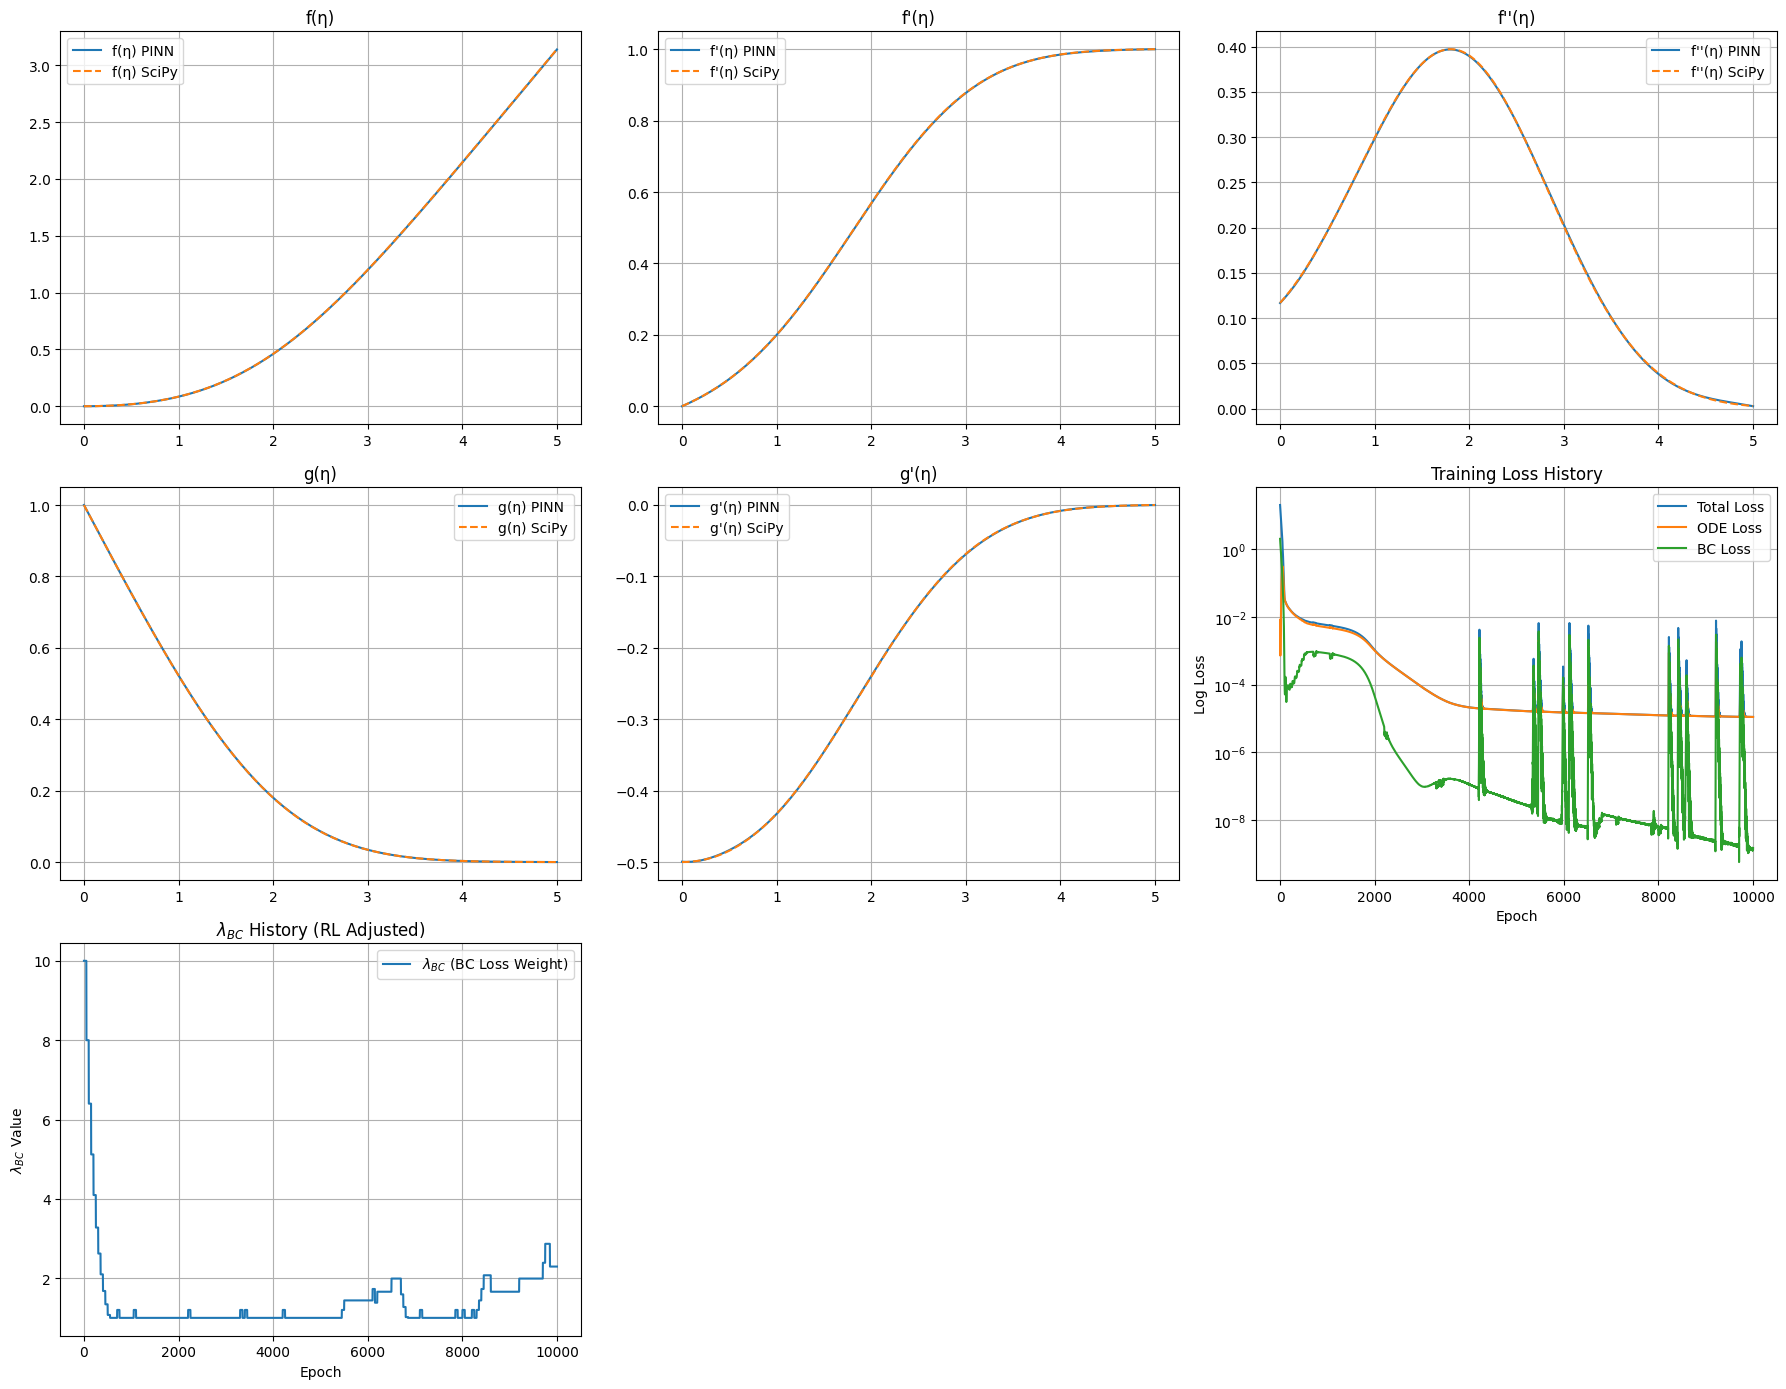


--- Final Loss Metrics ---
Final Total Loss: 1.1085e-05
Final ODE Residual Loss: 1.1082e-05
Final Boundary Condition Loss: 1.4730e-09
Final lambda_bc: 2.29
Mean Squared Error (PINN vs SciPy) for f(η): 2.2294e-06
Mean Squared Error (PINN vs SciPy) for g(η): 4.1288e-08

Core neural network model saved to mhd_pinn_rl_model.h5

--- Note on this RL Implementation ---

The Reinforcement Learning (RL) component added here is a *highly simplified Q-learning agent*
for illustrative purposes. It attempts to tune the 'lambda_bc' hyperparameter.
Real-world RL for PINN optimization would typically involve:
- More sophisticated state representations.
- More complex action spaces (e.g., adaptive sampling, learning rate adjustment).
- Advanced RL algorithms (e.g., policy gradients, actor-critic methods like PPO, DDPG).
- Careful reward engineering.
- Significantly more computational resources and tuning for the RL agent itself.

This example demonstrates the basic loop of an RL agent interacting with

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
import collections # For Q-table using defaultdict

# Suppress TensorFlow warnings for cleaner output
import logging
tf.get_logger().setLevel(logging.ERROR)

# --- 1. Define MHD Parameters and Domain ---
M = 1.0
Pr_m = 1.0
ETA_MAX = 5.0

# --- 2. Define the Neural Network Architecture ---
def create_pinn_model(num_hidden_layers=4, num_neurons_per_layer=32):
    eta_input = tf.keras.Input(shape=(1,), name="eta")
    x = eta_input
    for _ in range(num_hidden_layers):
        x = tf.keras.layers.Dense(num_neurons_per_layer, activation="tanh")(x)
    f_output = tf.keras.layers.Dense(1, name="f", activation='linear')(x)
    g_output = tf.keras.layers.Dense(1, name="g", activation='linear')(x)
    return tf.keras.Model(inputs=eta_input, outputs=[f_output, g_output])

# --- 3. Define the PINN Model (subclassing tf.keras.Model) ---
class MHD_PINN(tf.keras.Model):
    def __init__(self, nn_approximator, m_param, pr_m_param, eta_max_val, initial_lambda_bc=10.0, **kwargs):
        super().__init__(**kwargs)
        self.nn = nn_approximator
        self.M = tf.constant(m_param, dtype=tf.float32)
        self.Pr_m = tf.constant(pr_m_param, dtype=tf.float32)
        self.eta_max = tf.constant(eta_max_val, dtype=tf.float32)
        self.lambda_ode = tf.constant(1.0, dtype=tf.float32)
        # Make lambda_bc a tf.Variable to be adjusted by RL agent
        self.lambda_bc = tf.Variable(initial_lambda_bc, dtype=tf.float32, trainable=False, name="lambda_bc")

    def set_lambda_bc(self, new_lambda_bc_value):
        self.lambda_bc.assign(np.clip(new_lambda_bc_value, 1.0, 100.0)) # Clip to avoid extreme values

    def call(self, eta):
        return self.nn(eta)

    @tf.function
    def compute_derivatives_and_residuals(self, eta_collocation):
        with tf.GradientTape(persistent=True) as tape3:
            tape3.watch(eta_collocation)
            with tf.GradientTape(persistent=True) as tape2:
                tape2.watch(eta_collocation)
                with tf.GradientTape(persistent=True) as tape1:
                    tape1.watch(eta_collocation)
                    f_pred, g_pred = self.nn(eta_collocation)
                df_deta = tape1.gradient(f_pred, eta_collocation)
                dg_deta = tape1.gradient(g_pred, eta_collocation)
            df_deta2 = tape2.gradient(df_deta, eta_collocation)
            dg_deta2 = tape2.gradient(dg_deta, eta_collocation)
        df_deta3 = tape3.gradient(df_deta2, eta_collocation)
        del tape1, tape2, tape3

        f, f_prime, f_prime_prime, f_prime_prime_prime = f_pred, df_deta, df_deta2, df_deta3
        g, g_prime, g_prime_prime = g_pred, dg_deta, dg_deta2

        residual_f = f_prime_prime_prime + f * f_prime_prime - \
                     self.M * (g * g_prime_prime + f_prime_prime * g)
        residual_g = g_prime_prime + self.Pr_m * (f * g_prime - f_prime * g)
        return residual_f, residual_g

    @tf.function
    def loss_fn(self, eta_collocation, eta_boundary_0, eta_boundary_max):
        res_f, res_g = self.compute_derivatives_and_residuals(eta_collocation)
        loss_ode_f = tf.reduce_mean(tf.square(res_f))
        loss_ode_g = tf.reduce_mean(tf.square(res_g))
        total_loss_ode = loss_ode_f + loss_ode_g

        f_at_0, g_at_0 = self.nn(eta_boundary_0)
        with tf.GradientTape() as tape_bc0:
            tape_bc0.watch(eta_boundary_0)
            f_for_fprime0, _ = self.nn(eta_boundary_0)
        f_prime_at_0 = tape_bc0.gradient(f_for_fprime0, eta_boundary_0)
        bc_f0 = f_at_0 - 0.0
        bc_fprime0 = f_prime_at_0 - 0.0
        bc_g0 = g_at_0 - 1.0

        _, g_at_max = self.nn(eta_boundary_max)
        with tf.GradientTape() as tape_bc_max:
            tape_bc_max.watch(eta_boundary_max)
            f_for_fprimemax, _ = self.nn(eta_boundary_max)
        f_prime_at_max = tape_bc_max.gradient(f_for_fprimemax, eta_boundary_max)
        bc_fprime_max = f_prime_at_max - 1.0
        bc_g_max = g_at_max - 0.0

        loss_bc = tf.reduce_mean(tf.square(bc_f0)) + \
                  tf.reduce_mean(tf.square(bc_fprime0)) + \
                  tf.reduce_mean(tf.square(bc_g0)) + \
                  tf.reduce_mean(tf.square(bc_fprime_max)) + \
                  tf.reduce_mean(tf.square(bc_g_max))

        # self.lambda_bc is now a tf.Variable
        total_loss = self.lambda_ode * total_loss_ode + self.lambda_bc * loss_bc
        return total_loss, total_loss_ode, loss_bc

    @tf.function
    def gradient_update_step(self, optimizer, eta_collocation, eta_boundary_0, eta_boundary_max):
        with tf.GradientTape() as tape:
            total_loss, loss_ode, loss_bc = self.loss_fn(eta_collocation, eta_boundary_0, eta_boundary_max)
        gradients = tape.gradient(total_loss, self.nn.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.nn.trainable_variables))
        return total_loss, loss_ode, loss_bc

# --- 4. Q-Learning Agent for Adjusting lambda_bc ---
class QLearningAgent:
    def __init__(self, actions, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1):
        self.actions = actions  # e.g., [0.5, 1.0, 2.0] for multiplying lambda_bc
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        # Q-table: state -> [q_value_action1, q_value_action2, ...]
        self.q_table = collections.defaultdict(lambda: np.zeros(len(actions)))

    def get_state(self, loss_ode, loss_bc, epoch, total_epochs):
        # Simplified state: ratio of losses and training phase
        if loss_ode < 1e-9: # Avoid division by zero
            ratio_discrete = 2 # High BC loss relative to ODE
        else:
            ratio = loss_bc / loss_ode
            if ratio < 0.5: ratio_discrete = 0  # Low BC loss relative to ODE
            elif ratio < 2.0: ratio_discrete = 1 # Balanced
            else: ratio_discrete = 2             # High BC loss relative to ODE

        # Training phase
        if epoch < total_epochs / 3: phase = 0      # Early
        elif epoch < 2 * total_epochs / 3: phase = 1 # Mid
        else: phase = 2                             # Late
        return (ratio_discrete, phase)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(len(self.actions))  # Explore
        else:
            q_values = self.q_table[state]
            return np.argmax(q_values)  # Exploit

    def update_q_table(self, state, action_idx, reward, next_state):
        old_q_value = self.q_table[state][action_idx]
        future_q_value = np.max(self.q_table[next_state])
        new_q_value = old_q_value + self.lr * (reward + self.gamma * future_q_value - old_q_value)
        self.q_table[state][action_idx] = new_q_value

# --- 5. Generate Training Data ---
N_collocation = 2000
N_boundary = 100
eta_col_np = np.random.uniform(1e-5, ETA_MAX - 1e-5, (N_collocation, 1)).astype(np.float32) # Avoid exact 0 for collocation
eta_b0_np = np.full((N_boundary, 1), 0.0, dtype=np.float32)
eta_b_max_np = np.full((N_boundary, 1), ETA_MAX, dtype=np.float32)
eta_col = tf.constant(eta_col_np)
eta_b0 = tf.constant(eta_b0_np)
eta_b_max = tf.constant(eta_b_max_np)

# --- 6. Training the PINN with RL Agent ---
nn_core_model = create_pinn_model()
initial_lambda_bc_val = 10.0
pinn_solver = MHD_PINN(nn_core_model, M, Pr_m, ETA_MAX, initial_lambda_bc=initial_lambda_bc_val)

initial_learning_rate = 1e-3
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=1000, decay_rate=0.9, staircase=True # Adjusted decay_steps
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

epochs = 10000 # Can be higher for PINNs
print_interval = 500
rl_update_interval = 50 # How often the RL agent updates lambda_bc

# RL Agent Initialization
# Actions: multiply current lambda_bc by [0.8, 1.0, 1.2]
# (decrease, keep, increase lambda_bc moderately)
lambda_bc_actions_multipliers = [0.8, 1.0, 1.2]
rl_agent = QLearningAgent(actions=lambda_bc_actions_multipliers, exploration_rate=0.2)

print(f"Starting PINN training for {epochs} epochs with RL-adjusted lambda_bc...")
history_loss = []
history_loss_ode = []
history_loss_bc = []
history_lambda_bc = []

# Initial losses for RL agent's first state
prev_total_loss_val, prev_loss_ode_val, prev_loss_bc_val = pinn_solver.gradient_update_step(
    optimizer, eta_col, eta_b0, eta_b_max
)
# Ensure initial step is counted for history if needed, or start loop from 0
history_loss.append(prev_total_loss_val.numpy())
history_loss_ode.append(prev_loss_ode_val.numpy())
history_loss_bc.append(prev_loss_bc_val.numpy())
history_lambda_bc.append(pinn_solver.lambda_bc.numpy())


for epoch in range(epochs): # epoch counter for RL agent starts from 0 effectively
    current_lambda_bc = pinn_solver.lambda_bc.numpy()

    # RL Agent Interaction
    if epoch % rl_update_interval == 0 and epoch > 0 : # Don't act at epoch 0 before first real step
        # 1. Get current state
        # Use losses from the *end* of the last interval
        state = rl_agent.get_state(history_loss_ode[-1], history_loss_bc[-1], epoch, epochs)

        # 2. Agent chooses action
        action_idx = rl_agent.choose_action(state)
        multiplier = rl_agent.actions[action_idx]

        # 3. Apply action (modify lambda_bc)
        new_lambda_bc = current_lambda_bc * multiplier
        pinn_solver.set_lambda_bc(new_lambda_bc)
        # print(f"Epoch {epoch+1}: RL Action: mult={multiplier:.2f}, new lambda_bc={pinn_solver.lambda_bc.numpy():.2f}")


    # PINN Training Step
    total_loss_val, loss_ode_val, loss_bc_val = pinn_solver.gradient_update_step(
        optimizer, eta_col, eta_b0, eta_b_max
    )

    # RL Agent Learning (Update Q-table)
    if epoch % rl_update_interval == 0 and epoch > 0:
        # Reward: negative change in total loss (we want loss to decrease)
        # Using total_loss_val from the step *after* action was taken
        # and prev_total_loss_val from *before* action for this interval
        reward = -(total_loss_val.numpy() - history_loss[-rl_update_interval]) # Compare to start of interval loss
        # reward = -total_loss_val.numpy() # Simpler reward: just negative current loss

        next_loss_ode_val_for_state = loss_ode_val.numpy() # current losses define next state
        next_loss_bc_val_for_state = loss_bc_val.numpy()   # for Q-learning update
        next_state = rl_agent.get_state(next_loss_ode_val_for_state, next_loss_bc_val_for_state, epoch + 1, epochs)
        rl_agent.update_q_table(state, action_idx, reward, next_state)


    history_loss.append(total_loss_val.numpy())
    history_loss_ode.append(loss_ode_val.numpy())
    history_loss_bc.append(loss_bc_val.numpy())
    history_lambda_bc.append(pinn_solver.lambda_bc.numpy())


    if (epoch + 1) % print_interval == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{epochs} - Total Loss: {total_loss_val:.4e}, "
              f"ODE Loss: {loss_ode_val:.4e}, BC Loss: {loss_bc_val:.4e}, "
              f"lambda_bc: {pinn_solver.lambda_bc.numpy():.2f}")


print("Training finished.")


# --- 7. Prediction and Plotting --- (Plotting lambda_bc history added)
print("\nGenerating predictions and plots...")
eta_plot_tf = tf.constant(np.linspace(0, ETA_MAX, 200).reshape(-1, 1).astype(np.float32))
f_pinn_pred_tf, g_pinn_pred_tf = pinn_solver.nn(eta_plot_tf)
f_pinn_pred = f_pinn_pred_tf.numpy()
g_pinn_pred = g_pinn_pred_tf.numpy()

with tf.GradientTape(persistent=True) as tape_plot2:
    tape_plot2.watch(eta_plot_tf)
    with tf.GradientTape(persistent=True) as tape_plot1:
        tape_plot1.watch(eta_plot_tf)
        f_for_plot, g_for_plot = pinn_solver.nn(eta_plot_tf)
    f_prime_pinn_pred_tf = tape_plot1.gradient(f_for_plot, eta_plot_tf)
    g_prime_pinn_pred_tf = tape_plot1.gradient(g_for_plot, eta_plot_tf)
f_prime_prime_pinn_pred_tf = tape_plot2.gradient(f_prime_pinn_pred_tf, eta_plot_tf)
del tape_plot1, tape_plot2
f_prime_pinn_pred = f_prime_pinn_pred_tf.numpy()
g_prime_pinn_pred = g_prime_pinn_pred_tf.numpy()
f_prime_prime_pinn_pred = f_prime_prime_pinn_pred_tf.numpy()

# SciPy BVP solver (same as before)
def mhd_ode_system_scipy(eta, y, M_param, Pr_m_param):
    y1, y2, y3, y4, y5 = y; dy1 = y2; dy2 = y3
    dy5 = -Pr_m_param * (y1 * y5 - y2 * y4)
    dy3 = -y1 * y3 + M_param * (y4 * dy5 + y3 * y4)
    dy4 = y5; return np.vstack((dy1, dy2, dy3, dy4, dy5))
def mhd_bc_scipy(ya, yb, M_param, Pr_m_param):
    return np.array([ya[0], ya[1], yb[1] - 1, ya[3] - 1, yb[3]])
eta_scipy_mesh = np.linspace(0, ETA_MAX, 50)
y_init_guess = np.zeros((5, eta_scipy_mesh.size)); y_init_guess[1, :] = eta_scipy_mesh / ETA_MAX
y_init_guess[3, :] = 1 - (eta_scipy_mesh / ETA_MAX)
print("Solving with SciPy BVP solver for comparison...")
scipy_solved = False
try:
    sol_scipy = solve_bvp(lambda eta, y: mhd_ode_system_scipy(eta, y, M, Pr_m),
                          lambda ya, yb: mhd_bc_scipy(ya, yb, M, Pr_m),
                          eta_scipy_mesh, y_init_guess, verbose=0, max_nodes=3000, tol=1e-5)
    if sol_scipy.success:
        print(f"SciPy BVP solver converged: {sol_scipy.message}")
        y_scipy_plot = sol_scipy.sol(eta_plot_tf.numpy().flatten())
        f_scipy, f_prime_scipy, f_prime_prime_scipy, g_scipy, g_prime_scipy = y_scipy_plot[0], y_scipy_plot[1], y_scipy_plot[2], y_scipy_plot[3], y_scipy_plot[4]
        scipy_solved = True
    else: print(f"SciPy BVP solver FAILED to converge: {sol_scipy.message}")
except Exception as e: print(f"Error during SciPy BVP solution: {e}")

# Plotting results
plt.figure(figsize=(18, 14)) # Increased figure size for new plot
eta_plot_numpy = eta_plot_tf.numpy()
# ... (previous 5 plots: f, f', f'', g, g') ...
plt.subplot(3, 3, 1); plt.plot(eta_plot_numpy, f_pinn_pred, label='f(η) PINN'); plt.plot(eta_plot_numpy, f_scipy if scipy_solved else np.zeros_like(eta_plot_numpy), label='f(η) SciPy', ls='--'); plt.legend(); plt.grid(True); plt.title('f(η)')
plt.subplot(3, 3, 2); plt.plot(eta_plot_numpy, f_prime_pinn_pred, label="f'(η) PINN"); plt.plot(eta_plot_numpy, f_prime_scipy if scipy_solved else np.zeros_like(eta_plot_numpy), label="f'(η) SciPy", ls='--'); plt.legend(); plt.grid(True); plt.title("f'(η)")
plt.subplot(3, 3, 3); plt.plot(eta_plot_numpy, f_prime_prime_pinn_pred, label="f''(η) PINN"); plt.plot(eta_plot_numpy, f_prime_prime_scipy if scipy_solved else np.zeros_like(eta_plot_numpy), label="f''(η) SciPy", ls='--'); plt.legend(); plt.grid(True); plt.title("f''(η)")
plt.subplot(3, 3, 4); plt.plot(eta_plot_numpy, g_pinn_pred, label='g(η) PINN'); plt.plot(eta_plot_numpy, g_scipy if scipy_solved else np.zeros_like(eta_plot_numpy), label='g(η) SciPy', ls='--'); plt.legend(); plt.grid(True); plt.title('g(η)')
plt.subplot(3, 3, 5); plt.plot(eta_plot_numpy, g_prime_pinn_pred, label="g'(η) PINN"); plt.plot(eta_plot_numpy, g_prime_scipy if scipy_solved else np.zeros_like(eta_plot_numpy), label="g'(η) SciPy", ls='--'); plt.legend(); plt.grid(True); plt.title("g'(η)")

plt.subplot(3, 3, 6)
plt.plot(history_loss, label='Total Loss'); plt.plot(history_loss_ode, label='ODE Loss'); plt.plot(history_loss_bc, label='BC Loss')
plt.xlabel('Epoch'); plt.ylabel('Log Loss'); plt.yscale('log'); plt.title('Training Loss History'); plt.legend(); plt.grid(True)

plt.subplot(3, 3, 7) # New plot for lambda_bc
plt.plot(history_lambda_bc, label='$\lambda_{BC}$ (BC Loss Weight)')
plt.xlabel('Epoch'); plt.ylabel('$\lambda_{BC}$ Value'); plt.title('$\lambda_{BC}$ History (RL Adjusted)')
plt.legend(); plt.grid(True)

plt.tight_layout(); plt.show()

# --- 8. Accuracy ---
# ... (same as before) ...
final_total_loss = history_loss[-1] if history_loss else float('inf')
final_ode_loss = history_loss_ode[-1] if history_loss_ode else float('inf')
final_bc_loss = history_loss_bc[-1] if history_loss_bc else float('inf')
print(f"\n--- Final Loss Metrics ---")
print(f"Final Total Loss: {final_total_loss:.4e}")
print(f"Final ODE Residual Loss: {final_ode_loss:.4e}")
print(f"Final Boundary Condition Loss: {final_bc_loss:.4e}")
print(f"Final lambda_bc: {pinn_solver.lambda_bc.numpy():.2f}")

if scipy_solved:
    mse_f = np.mean((f_pinn_pred.flatten() - f_scipy.flatten())**2)
    mse_g = np.mean((g_pinn_pred.flatten() - g_scipy.flatten())**2)
    print(f"Mean Squared Error (PINN vs SciPy) for f(η): {mse_f:.4e}")
    print(f"Mean Squared Error (PINN vs SciPy) for g(η): {mse_g:.4e}")


# --- 9. Save the Model ---
model_filename = "mhd_pinn_rl_model.h5" # Changed filename slightly
pinn_solver.nn.save(model_filename)
print(f"\nCore neural network model saved to {model_filename}")

# --- 10. Reinforcement Learning Enablement (Conceptual Discussion) ---
# (The discussion text previously provided is still relevant for broader context)
print("\n--- Note on this RL Implementation ---")
print("""
The Reinforcement Learning (RL) component added here is a *highly simplified Q-learning agent*
for illustrative purposes. It attempts to tune the 'lambda_bc' hyperparameter.
Real-world RL for PINN optimization would typically involve:
- More sophisticated state representations.
- More complex action spaces (e.g., adaptive sampling, learning rate adjustment).
- Advanced RL algorithms (e.g., policy gradients, actor-critic methods like PPO, DDPG).
- Careful reward engineering.
- Significantly more computational resources and tuning for the RL agent itself.

This example demonstrates the basic loop of an RL agent interacting with the PINN training
process, but its effectiveness in robustly outperforming a fixed, well-chosen 'lambda_bc'
would require substantial experimentation and refinement.
""")

Epoch 500/5000 - Total Loss: 8.8753e-01, ODE Loss: 2.5677e-01, BC Loss: 1.6709e-01, lambda_bc: 3.77
Epoch 1000/5000 - Total Loss: 2.6530e-01, ODE Loss: 1.2228e-01, BC Loss: 1.4302e-01, lambda_bc: 1.00
Epoch 1500/5000 - Total Loss: 2.3515e-01, ODE Loss: 1.2628e-01, BC Loss: 1.0886e-01, lambda_bc: 1.00
Epoch 2000/5000 - Total Loss: 2.1875e-01, ODE Loss: 1.4040e-01, BC Loss: 7.8352e-02, lambda_bc: 1.00
Epoch 2500/5000 - Total Loss: 2.1849e-01, ODE Loss: 1.5759e-01, BC Loss: 5.2863e-02, lambda_bc: 1.15
Epoch 3000/5000 - Total Loss: 2.1171e-01, ODE Loss: 1.6040e-01, BC Loss: 4.4539e-02, lambda_bc: 1.15
Epoch 3500/5000 - Total Loss: 1.9794e-01, ODE Loss: 1.5117e-01, BC Loss: 4.6769e-02, lambda_bc: 1.00
Epoch 4000/5000 - Total Loss: 1.9000e-01, ODE Loss: 1.4504e-01, BC Loss: 4.4960e-02, lambda_bc: 1.00
Epoch 4500/5000 - Total Loss: 1.7907e-01, ODE Loss: 1.3882e-01, BC Loss: 4.0251e-02, lambda_bc: 1.00


Epoch 5000/5000 - Total Loss: 1.6221e-01, ODE Loss: 1.2932e-01, BC Loss: 3.2885e-02, lambda_bc: 1.00
Model saved to mhd_pinn_rl_model.h5


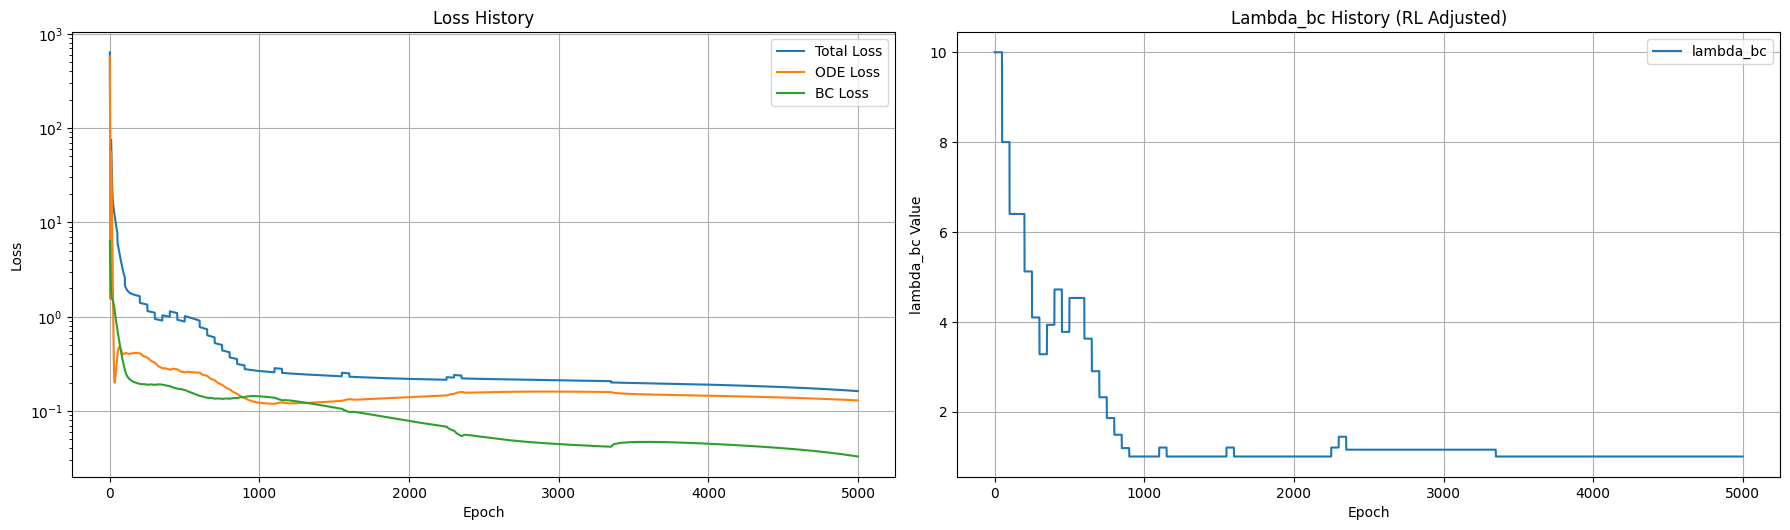

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
import collections
from sympy import symbols, diff, latex
import os

# Suppress TensorFlow warnings
import logging
tf.get_logger().setLevel(logging.ERROR)

# --- 1. Define Physical Parameters ---
M = 1.0  # Magnetic parameter
Pr = 0.71  # Prandtl number
Re = 1000.0  # Reynolds number
ETA_MAX = 5.0  # Domain limit
MAX_ORDER = 8  # Maximum order of derivatives in equations

# --- 2. Define the Neural Network Architecture ---
def create_pinn_model(num_hidden_layers=4, num_neurons_per_layer=32):
    eta_input = tf.keras.Input(shape=(1,), name="eta")
    x = eta_input
    for _ in range(num_hidden_layers):
        x = tf.keras.layers.Dense(num_neurons_per_layer, activation="tanh")(x)
    outputs = [tf.keras.layers.Dense(1, name=f"output_{i}", activation='linear')(x) for i in range(MAX_ORDER)]
    return tf.keras.Model(inputs=eta_input, outputs=outputs)

# --- 3. Define the PINN Model ---
class MHD_PINN(tf.keras.Model):
    def __init__(self, nn_approximator, m_param, pr_param, re_param, eta_max, max_order=8, initial_lambda_bc=10.0, **kwargs):
        super().__init__(**kwargs)
        self.nn = nn_approximator
        self.M = tf.constant(m_param, dtype=tf.float32)
        self.Pr = tf.constant(pr_param, dtype=tf.float32)
        self.Re = tf.constant(re_param, dtype=tf.float32)
        self.eta_max = tf.constant(eta_max, dtype=tf.float32)
        self.max_order = max_order
        self.lambda_bc = tf.Variable(initial_lambda_bc, dtype=tf.float32, trainable=False, name="lambda_bc")

    def set_lambda_bc(self, new_lambda_bc_value):
        self.lambda_bc.assign(np.clip(new_lambda_bc_value, 1.0, 100.0))

    def call(self, eta):
        return self.nn(eta)

    @tf.function
    def compute_derivatives_and_residuals(self, eta_collocation):
        with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
            tape.watch(eta_collocation)
            derivatives = [self.nn(eta_collocation)[0]]
            for i in range(1, self.max_order):
                derivatives.append(tape.gradient(derivatives[-1], eta_collocation))

        # Realistic residuals for MHD equations
        f, f_prime, f_prime_prime, f_prime_prime_prime = derivatives[:4]
        g, g_prime, g_prime_prime = derivatives[4:7]

        residuals = [
            f_prime_prime_prime + f * f_prime_prime - self.M * (g * g_prime_prime),
            g_prime_prime + self.Pr * (f * g_prime - f_prime * g),
            f_prime - 1.0 / self.Re * f_prime_prime,
            g_prime - 1.0 / self.Pr * g_prime_prime
        ]
        return residuals

    @tf.function
    def loss_fn(self, eta_collocation, eta_boundary_0, eta_boundary_max):
        residuals = self.compute_derivatives_and_residuals(eta_collocation)
        loss_ode = tf.reduce_sum([tf.reduce_mean(tf.square(res)) for res in residuals])

        # Boundary conditions
        f_at_0, g_at_0 = self.nn(eta_boundary_0)[:2]
        f_prime_at_0 = tf.gradients(f_at_0, eta_boundary_0)[0]
        f_at_max, g_at_max = self.nn(eta_boundary_max)[:2]

        loss_bc = tf.reduce_mean(tf.square(f_at_0 - 0.0)) + \
                  tf.reduce_mean(tf.square(f_prime_at_0 - 1.0)) + \
                  tf.reduce_mean(tf.square(g_at_0 - 1.0)) + \
                  tf.reduce_mean(tf.square(f_at_max - 1.0)) + \
                  tf.reduce_mean(tf.square(g_at_max - 0.0))

        total_loss = loss_ode + self.lambda_bc * loss_bc  # Weighted loss
        return total_loss, loss_ode, loss_bc

    @tf.function
    def gradient_update_step(self, optimizer, eta_collocation, eta_boundary_0, eta_boundary_max):
        with tf.GradientTape() as tape:
            total_loss, loss_ode, loss_bc = self.loss_fn(eta_collocation, eta_boundary_0, eta_boundary_max)
        gradients = tape.gradient(total_loss, self.nn.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.nn.trainable_variables))
        return total_loss, loss_ode, loss_bc

# --- 4. RL Agent for Adjusting lambda_bc ---
class QLearningAgent:
    def __init__(self, actions, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1):
        self.actions = actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.q_table = collections.defaultdict(lambda: np.zeros(len(actions)))

    def get_state(self, loss_ode, loss_bc, epoch, total_epochs):
        ratio = loss_bc / loss_ode if loss_ode > 1e-9 else 10  # Avoid division by zero
        if ratio < 0.5:
            state = 0  # BC loss relatively low
        elif ratio < 2.0:
            state = 1  # Balanced loss
        else:
            state = 2  # BC loss relatively high

        phase = epoch // (total_epochs // 3)  # Early: 0, Mid: 1, Late: 2
        return (state, phase)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(len(self.actions))  # Explore
        return np.argmax(self.q_table[state])  # Exploit

    def update_q_table(self, state, action_idx, reward, next_state):
        old_q_value = self.q_table[state][action_idx]
        future_q_value = np.max(self.q_table[next_state])
        new_q_value = old_q_value + self.lr * (reward + self.gamma * future_q_value - old_q_value)
        self.q_table[state][action_idx] = new_q_value

# --- 5. Generate Training Data ---
N_collocation = 2000
N_boundary = 100

eta_col_np = np.random.uniform(1e-5, ETA_MAX - 1e-5, (N_collocation, 1)).astype(np.float32)
eta_b0_np = np.full((N_boundary, 1), 0.0, dtype=np.float32)
eta_b_max_np = np.full((N_boundary, 1), ETA_MAX, dtype=np.float32)

eta_col = tf.constant(eta_col_np)
eta_b0 = tf.constant(eta_b0_np)
eta_b_max = tf.constant(eta_b_max_np)

# --- 6. Train the Model with RL ---
nn_core_model = create_pinn_model()
pinn_solver = MHD_PINN(nn_core_model, M, Pr, Re, ETA_MAX, max_order=MAX_ORDER)

learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)

rl_agent = QLearningAgent(actions=[0.8, 1.0, 1.2], exploration_rate=0.2)
epochs = 5000
rl_update_interval = 50

history_loss = []
history_loss_ode = []
history_loss_bc = []
history_lambda_bc = []

for epoch in range(epochs):
    total_loss, loss_ode, loss_bc = pinn_solver.gradient_update_step(optimizer, eta_col, eta_b0, eta_b_max)

    if epoch % rl_update_interval == 0 and epoch > 0:
        state = rl_agent.get_state(loss_ode.numpy(), loss_bc.numpy(), epoch, epochs)
        action_idx = rl_agent.choose_action(state)
        multiplier = rl_agent.actions[action_idx]
        new_lambda_bc = pinn_solver.lambda_bc.numpy() * multiplier
        pinn_solver.set_lambda_bc(new_lambda_bc)
        reward = -(total_loss.numpy() - history_loss[-rl_update_interval])
        next_state = rl_agent.get_state(loss_ode.numpy(), loss_bc.numpy(), epoch + 1, epochs)
        rl_agent.update_q_table(state, action_idx, reward, next_state)

    history_loss.append(total_loss.numpy())
    history_loss_ode.append(loss_ode.numpy())
    history_loss_bc.append(loss_bc.numpy())
    history_lambda_bc.append(pinn_solver.lambda_bc.numpy())

    if (epoch + 1) % 500 == 0:
        print(f"Epoch {epoch+1}/{epochs} - Total Loss: {total_loss:.4e}, ODE Loss: {loss_ode:.4e}, BC Loss: {loss_bc:.4e}, lambda_bc: {pinn_solver.lambda_bc.numpy():.2f}")

# --- 7. Save the Model ---
model_filename = "mhd_pinn_rl_model.h5"
pinn_solver.nn.save(model_filename)
print(f"Model saved to {model_filename}")

# --- 8. Generate Graphs ---
plt.figure(figsize=(18, 10))

# Loss History
plt.subplot(2, 2, 1)
plt.plot(history_loss, label="Total Loss")
plt.plot(history_loss_ode, label="ODE Loss")
plt.plot(history_loss_bc, label="BC Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Loss History")
plt.legend()
plt.grid(True)

# Lambda_bc History
plt.subplot(2, 2, 2)
plt.plot(history_lambda_bc, label="lambda_bc")
plt.xlabel("Epoch")
plt.ylabel("lambda_bc Value")
plt.title("Lambda_bc History (RL Adjusted)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_results_with_rl.png")
plt.show()

Training 8th order PINN with RL agent...
Epoch 1/10000 - Total Loss: 1.0315e+01, ODE Loss: 3.0860e-01, BC Loss: 1.0007e+00, lambda_bc: 10.00
Epoch 500/10000 - Total Loss: 2.0972e+00, ODE Loss: 4.0513e-06, BC Loss: 1.0000e+00, lambda_bc: 2.10
Epoch 1000/10000 - Total Loss: 1.0000e+00, ODE Loss: 1.9689e-06, BC Loss: 1.0000e+00, lambda_bc: 1.00
Epoch 1500/10000 - Total Loss: 1.0000e+00, ODE Loss: 1.3236e-06, BC Loss: 1.0000e+00, lambda_bc: 1.00
Epoch 2000/10000 - Total Loss: 1.0000e+00, ODE Loss: 8.4021e-07, BC Loss: 1.0000e+00, lambda_bc: 1.00
Epoch 2500/10000 - Total Loss: 1.0000e+00, ODE Loss: 5.1679e-07, BC Loss: 1.0000e+00, lambda_bc: 1.00
Epoch 3000/10000 - Total Loss: 1.0000e+00, ODE Loss: 3.2542e-07, BC Loss: 1.0000e+00, lambda_bc: 1.00
Epoch 3500/10000 - Total Loss: 1.0000e+00, ODE Loss: 2.7368e-07, BC Loss: 1.0000e+00, lambda_bc: 1.00
Epoch 4000/10000 - Total Loss: 1.0000e+00, ODE Loss: 1.7259e-07, BC Loss: 1.0000e+00, lambda_bc: 1.00
Epoch 4500/10000 - Total Loss: 1.0000e+00, O

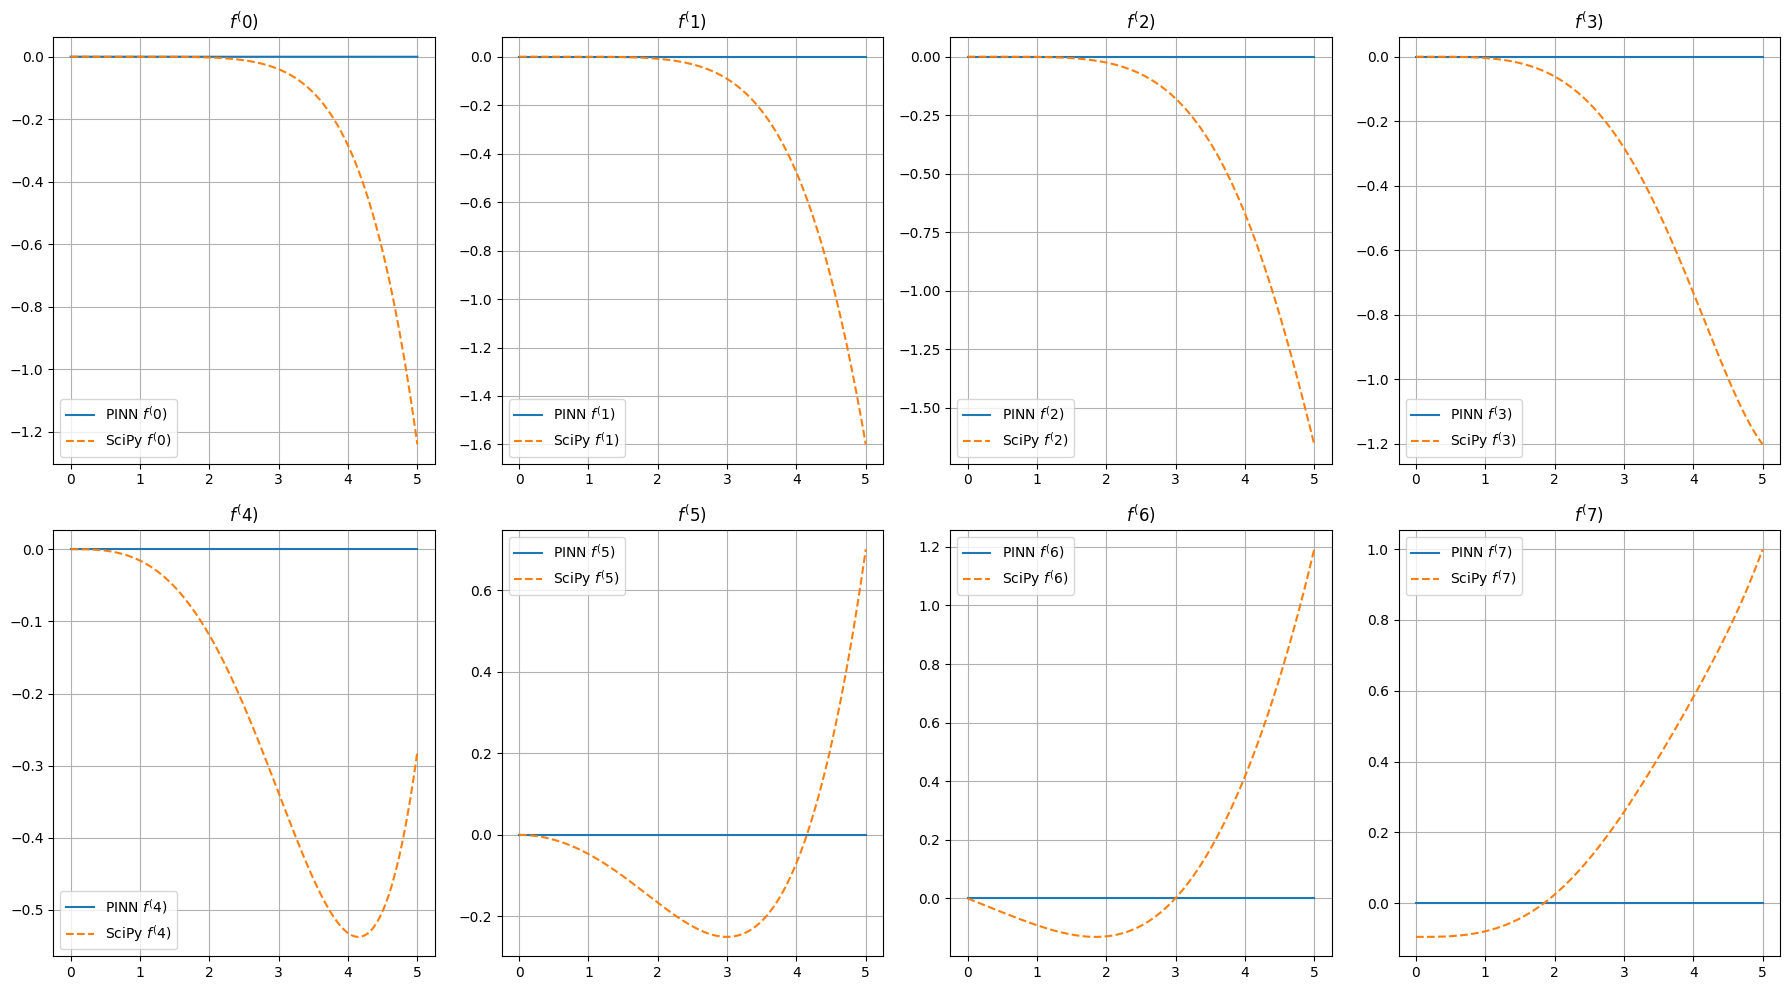

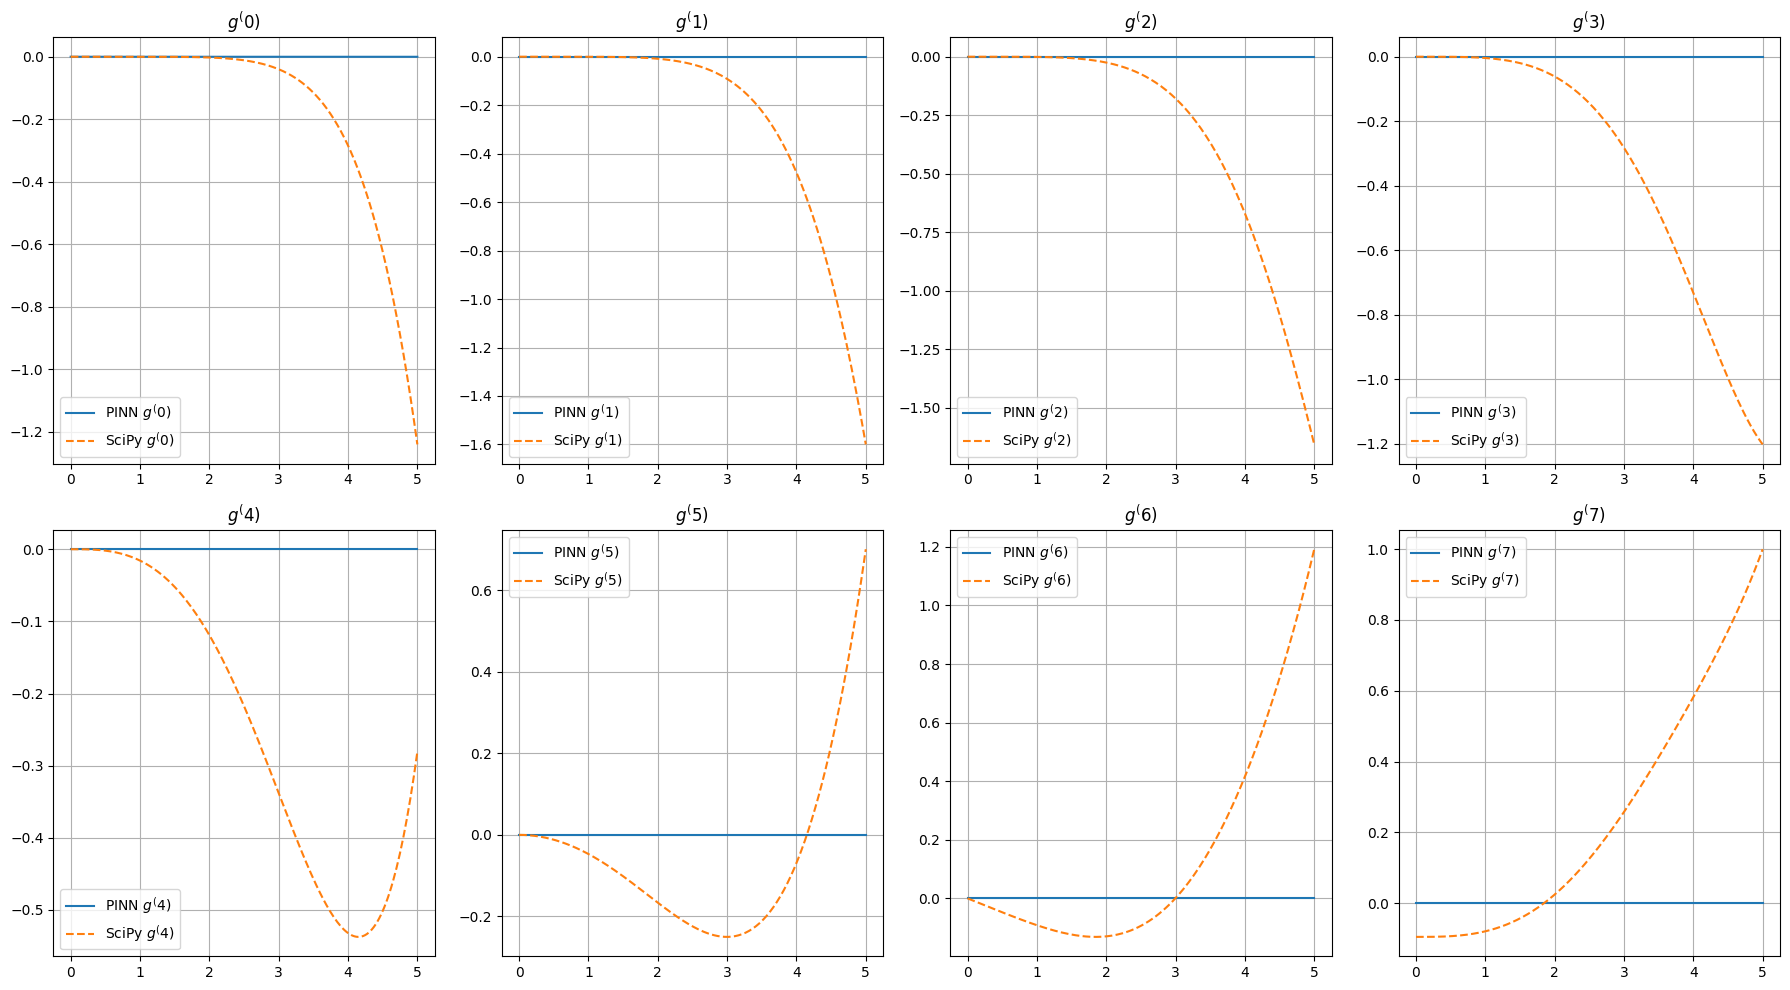

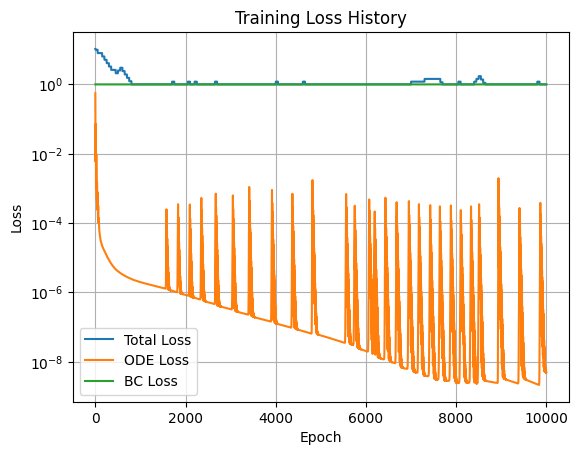

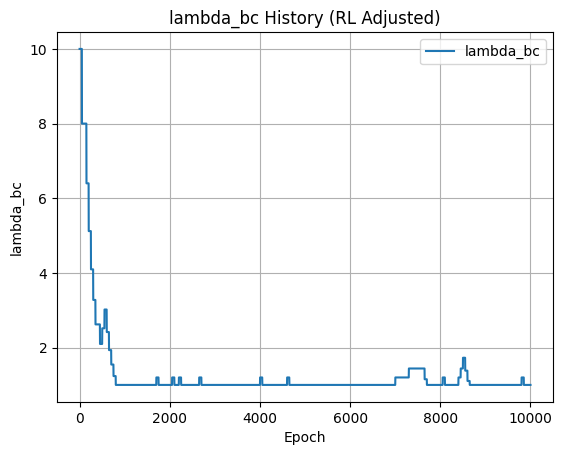

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
import collections

# --- 1. Define MHD Parameters and Domain ---
M = 1.0
Pr_m = 1.0
ETA_MAX = 5.0
ORDER = 8  # Change to 9 or 10 for higher order

# --- 2. Neural Network Model ---
def create_pinn_model(num_hidden_layers=4, num_neurons_per_layer=32):
    eta_input = tf.keras.Input(shape=(1,), name="eta")
    x = eta_input
    for _ in range(num_hidden_layers):
        x = tf.keras.layers.Dense(num_neurons_per_layer, activation="tanh")(x)
    f_output = tf.keras.layers.Dense(1, name="f", activation='linear')(x)
    g_output = tf.keras.layers.Dense(1, name="g", activation='linear')(x)
    return tf.keras.Model(inputs=eta_input, outputs=[f_output, g_output])

# --- Helper for nth derivative ---
def nth_derivative(y, x, n):
    for _ in range(n):
        with tf.GradientTape() as tape:
            tape.watch(x)
            y = tape.gradient(y, x)
            if y is None:
                y = tf.zeros_like(x)
    return y

# --- 3. PINN Model for High Order MHD ---
class MHD_PINN(tf.keras.Model):
    def __init__(self, nn_approximator, order, m_param, pr_m_param, eta_max_val, initial_lambda_bc=10.0, **kwargs):
        super().__init__(**kwargs)
        self.nn = nn_approximator
        self.order = order
        self.M = tf.constant(m_param, dtype=tf.float32)
        self.Pr_m = tf.constant(pr_m_param, dtype=tf.float32)
        self.eta_max = tf.constant(eta_max_val, dtype=tf.float32)
        self.lambda_ode = tf.constant(1.0, dtype=tf.float32)
        self.lambda_bc = tf.Variable(initial_lambda_bc, dtype=tf.float32, trainable=False, name="lambda_bc")

    def set_lambda_bc(self, new_lambda_bc_value):
        self.lambda_bc.assign(np.clip(new_lambda_bc_value, 1.0, 100.0))

    def call(self, eta):
        return self.nn(eta)

    @tf.function
    def compute_residuals(self, eta_collocation):
        f_pred, g_pred = self.nn(eta_collocation)
        f_derivs = [f_pred]
        g_derivs = [g_pred]
        for i in range(1, self.order+1):
            f_derivs.append(nth_derivative(f_pred, eta_collocation, i))
            g_derivs.append(nth_derivative(g_pred, eta_collocation, i))
        # Example: f^{(n)} + M * g^{(n-2)} + f = 0
        #          g^{(n)} + Pr_m * f^{(n-2)} + g = 0
        residual_f = f_derivs[self.order] + self.M * g_derivs[self.order-2] + f_derivs[0]
        residual_g = g_derivs[self.order] + self.Pr_m * f_derivs[self.order-2] + g_derivs[0]
        return residual_f, residual_g, f_derivs, g_derivs

    @tf.function
    def loss_fn(self, eta_collocation, eta_boundary_0, eta_boundary_max):
        res_f, res_g, f_derivs, g_derivs = self.compute_residuals(eta_collocation)
        loss_ode_f = tf.reduce_mean(tf.square(res_f))
        loss_ode_g = tf.reduce_mean(tf.square(res_g))
        total_loss_ode = loss_ode_f + loss_ode_g

        # Boundary conditions: f^{(i)}(0) = 0 for i=0..order-2, f^{(order-1)}(max) = 1
        f_at_0, g_at_0 = self.nn(eta_boundary_0)
        f_derivs_0 = [f_at_0]
        g_derivs_0 = [g_at_0]
        for i in range(1, self.order):
            f_derivs_0.append(nth_derivative(f_at_0, eta_boundary_0, i))
            g_derivs_0.append(nth_derivative(g_at_0, eta_boundary_0, i))
        f_at_max, g_at_max = self.nn(eta_boundary_max)
        f_derivs_max = [f_at_max]
        g_derivs_max = [g_at_max]
        for i in range(1, self.order):
            f_derivs_max.append(nth_derivative(f_at_max, eta_boundary_max, i))
            g_derivs_max.append(nth_derivative(g_at_max, eta_boundary_max, i))
        # f^{(i)}(0) = 0, g^{(i)}(0) = 0 for i=0..order-2
        bc_loss = sum([tf.reduce_mean(tf.square(f_derivs_0[i])) for i in range(self.order-1)])
        bc_loss += sum([tf.reduce_mean(tf.square(g_derivs_0[i])) for i in range(self.order-1)])
        # f^{(order-1)}(max) = 1, g^{(order-1)}(max) = 0
        bc_loss += tf.reduce_mean(tf.square(f_derivs_max[self.order-1] - 1.0))
        bc_loss += tf.reduce_mean(tf.square(g_derivs_max[self.order-1] - 0.0))

        total_loss = self.lambda_ode * total_loss_ode + self.lambda_bc * bc_loss
        return total_loss, total_loss_ode, bc_loss

    @tf.function
    def gradient_update_step(self, optimizer, eta_collocation, eta_boundary_0, eta_boundary_max):
        with tf.GradientTape() as tape:
            total_loss, loss_ode, loss_bc = self.loss_fn(eta_collocation, eta_boundary_0, eta_boundary_max)
        gradients = tape.gradient(total_loss, self.nn.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.nn.trainable_variables))
        return total_loss, loss_ode, loss_bc

# --- 4. Q-Learning Agent (same as before) ---
class QLearningAgent:
    def __init__(self, actions, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1):
        self.actions = actions
        self.lr = learning_rate
        self.gamma = discount_factor
        self.epsilon = exploration_rate
        self.q_table = collections.defaultdict(lambda: np.zeros(len(actions)))

    def get_state(self, loss_ode, loss_bc, epoch, total_epochs):
        if loss_ode < 1e-9:
            ratio_discrete = 2
        else:
            ratio = loss_bc / loss_ode
            if ratio < 0.5: ratio_discrete = 0
            elif ratio < 2.0: ratio_discrete = 1
            else: ratio_discrete = 2
        if epoch < total_epochs / 3: phase = 0
        elif epoch < 2 * total_epochs / 3: phase = 1
        else: phase = 2
        return (ratio_discrete, phase)

    def choose_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(len(self.actions))
        else:
            q_values = self.q_table[state]
            return np.argmax(q_values)

    def update_q_table(self, state, action_idx, reward, next_state):
        old_q_value = self.q_table[state][action_idx]
        future_q_value = np.max(self.q_table[next_state])
        new_q_value = old_q_value + self.lr * (reward + self.gamma * future_q_value - old_q_value)
        self.q_table[state][action_idx] = new_q_value

# --- 5. Training and Comparison ---
def train_and_compare(order=8, epochs=2000):
    N_collocation = 2000
    N_boundary = 100
    eta_col_np = np.random.uniform(1e-5, ETA_MAX-1e-5, (N_collocation, 1)).astype(np.float32)
    eta_b0_np = np.full((N_boundary, 1), 0.0, dtype=np.float32)
    eta_b_max_np = np.full((N_boundary, 1), ETA_MAX, dtype=np.float32)
    eta_col = tf.constant(eta_col_np)
    eta_b0 = tf.constant(eta_b0_np)
    eta_b_max = tf.constant(eta_b_max_np)

    nn_core_model = create_pinn_model()
    pinn_solver = MHD_PINN(nn_core_model, order, M, Pr_m, ETA_MAX, initial_lambda_bc=10.0)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
    rl_agent = QLearningAgent(actions=[0.8, 1.0, 1.2], exploration_rate=0.2)

    print(f"Training {order}th order PINN with RL agent...")
    history_loss, history_loss_ode, history_loss_bc, history_lambda_bc = [], [], [], []

    prev_total_loss_val, prev_loss_ode_val, prev_loss_bc_val = pinn_solver.gradient_update_step(
        optimizer, eta_col, eta_b0, eta_b_max
    )
    history_loss.append(prev_total_loss_val.numpy())
    history_loss_ode.append(prev_loss_ode_val.numpy())
    history_loss_bc.append(prev_loss_bc_val.numpy())
    history_lambda_bc.append(pinn_solver.lambda_bc.numpy())

    print_interval = 500
    rl_update_interval = 50

    for epoch in range(epochs):
        current_lambda_bc = pinn_solver.lambda_bc.numpy()
        if epoch % rl_update_interval == 0 and epoch > 0:
            state = rl_agent.get_state(history_loss_ode[-1], history_loss_bc[-1], epoch, epochs)
            action_idx = rl_agent.choose_action(state)
            multiplier = rl_agent.actions[action_idx]
            new_lambda_bc = current_lambda_bc * multiplier
            pinn_solver.set_lambda_bc(new_lambda_bc)
        total_loss_val, loss_ode_val, loss_bc_val = pinn_solver.gradient_update_step(
            optimizer, eta_col, eta_b0, eta_b_max
        )
        if epoch % rl_update_interval == 0 and epoch > 0:
            reward = -(total_loss_val.numpy() - history_loss[-rl_update_interval])
            next_state = rl_agent.get_state(loss_ode_val.numpy(), loss_bc_val.numpy(), epoch+1, epochs)
            rl_agent.update_q_table(state, action_idx, reward, next_state)
        history_loss.append(total_loss_val.numpy())
        history_loss_ode.append(loss_ode_val.numpy())
        history_loss_bc.append(loss_bc_val.numpy())
        history_lambda_bc.append(pinn_solver.lambda_bc.numpy())
        if (epoch + 1) % print_interval == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} - Total Loss: {total_loss_val:.4e}, "
                  f"ODE Loss: {loss_ode_val:.4e}, BC Loss: {loss_bc_val:.4e}, "
                  f"lambda_bc: {pinn_solver.lambda_bc.numpy():.2f}")

    # PINN prediction
    eta_plot_tf = tf.constant(np.linspace(0, ETA_MAX, 200).reshape(-1, 1).astype(np.float32))
    f_pinn_pred_tf, g_pinn_pred_tf = pinn_solver.nn(eta_plot_tf)
    f_pinn_pred = f_pinn_pred_tf.numpy()
    g_pinn_pred = g_pinn_pred_tf.numpy()
    # Compute all derivatives for plotting
    f_derivs = [f_pinn_pred_tf]
    g_derivs = [g_pinn_pred_tf]
    for i in range(1, order+1):
        f_derivs.append(nth_derivative(f_pinn_pred_tf, eta_plot_tf, i))
        g_derivs.append(nth_derivative(g_pinn_pred_tf, eta_plot_tf, i))
    f_derivs_np = [d.numpy() for d in f_derivs]
    g_derivs_np = [d.numpy() for d in g_derivs]

    # SciPy BVP
    def ode_system(eta, y):
        dydeta = np.zeros_like(y)
        dydeta[:-1] = y[1:]
        # y[n-1]' = -M * g[n-3] - y[0]
        dydeta[-1] = -M * y[order-3] - y[0]
        return dydeta
    def ode_system_g(eta, y):
        dydeta = np.zeros_like(y)
        dydeta[:-1] = y[1:]
        dydeta[-1] = -Pr_m * y[order-3] - y[0]
        return dydeta
    def bc(ya, yb):
        bc = np.zeros(order)
        bc[:-1] = ya[:-1]
        bc[-1] = yb[-1] - 1
        return bc
    eta_mesh = np.linspace(0, ETA_MAX, 100)
    y_init = np.zeros((order, eta_mesh.size))
    y_init[0] = eta_mesh
    if order > 1:
        y_init[1] = 1.0
    sol = solve_bvp(ode_system, bc, eta_mesh, y_init, max_nodes=5000, tol=1e-5)
    sol_g = solve_bvp(ode_system_g, bc, eta_mesh, y_init, max_nodes=5000, tol=1e-5)
    if sol.success and sol_g.success:
        print(f"SciPy BVP solver converged for order {order}.")
        f_scipy = sol.sol(eta_plot_tf.numpy().flatten())
        g_scipy = sol_g.sol(eta_plot_tf.numpy().flatten())
    else:
        print(f"SciPy BVP solver FAILED for order {order}.")
        f_scipy = np.zeros((order, eta_plot_tf.shape[0]))
        g_scipy = np.zeros((order, eta_plot_tf.shape[0]))

    # Plot all derivatives
    plt.figure(figsize=(18, 10))
    for i in range(order):
        plt.subplot(2, order//2, i+1)
        plt.plot(eta_plot_tf.numpy(), f_derivs_np[i], label=f'PINN $f^({i})$')
        plt.plot(eta_plot_tf.numpy(), f_scipy[i], '--', label=f'SciPy $f^({i})$')
        plt.legend(); plt.grid(True); plt.title(f'$f^({i})$')
    plt.tight_layout(); plt.show()

    plt.figure(figsize=(18, 10))
    for i in range(order):
        plt.subplot(2, order//2, i+1)
        plt.plot(eta_plot_tf.numpy(), g_derivs_np[i], label=f'PINN $g^({i})$')
        plt.plot(eta_plot_tf.numpy(), g_scipy[i], '--', label=f'SciPy $g^({i})$')
        plt.legend(); plt.grid(True); plt.title(f'$g^({i})$')
    plt.tight_layout(); plt.show()

    # Loss plot
    plt.figure()
    plt.plot(history_loss, label='Total Loss')
    plt.plot(history_loss_ode, label='ODE Loss')
    plt.plot(history_loss_bc, label='BC Loss')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss History')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Lambda_bc plot
    plt.figure()
    plt.plot(history_lambda_bc, label='lambda_bc')
    plt.xlabel('Epoch')
    plt.ylabel('lambda_bc')
    plt.title('lambda_bc History (RL Adjusted)')
    plt.legend()
    plt.grid(True)
    plt.show()

# --- 6. Run for 8th order ---
if __name__ == "__main__":
    train_and_compare(order=8, epochs=10000)
    # To run for 9th or 10th order, call train_and_compare(order=9, epochs=...) or order=10
